<h3>12.1 Deep Dream模型</h3>

<h3>12.1.1 Deep Dream原理</h3>

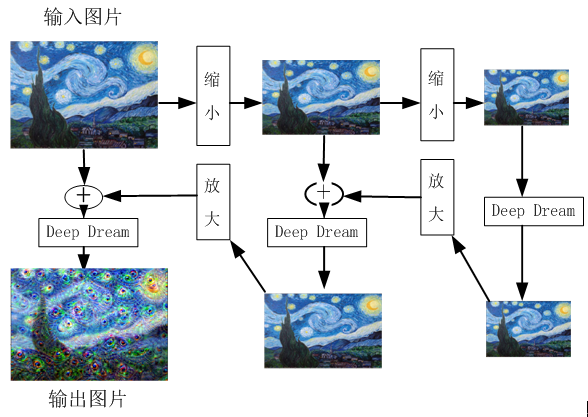

<h3>12.1.3 用Pytorch实现Deep Dream</h3>

In [13]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [14]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

def deprocess(image):
    images=image * torch.tensor([0.229, 0.224, 0.225],device=device)  + torch.tensor([0.485, 0.456, 0.406],device=device)
    return  images


In [15]:
#下载预训练模型vgg19
vgg = models.vgg19(pretrained=True)
vgg = vgg.to(device)
print(vgg)
modulelist = list(vgg.features.modules())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [16]:
def prod(image, layer, iterations, lr):   
    input = preprocess(image).unsqueeze(0)
    input=input.to(device).requires_grad_(True)
    vgg.zero_grad()
    for i in range(iterations):
        out = input
        for j in range(layer):
            out = modulelist[j+1](out)
        #以特征值的L2为损失值    
        loss = out.norm()
        loss.backward()
        #使梯度增大
        with torch.no_grad():
            input += lr * input.grad
            
    
    input = input.squeeze()
    #交互维度
    input.transpose_(0,1)
    input.transpose_(1,2)
    #使数据限制在[0,1]之间
    input = np.clip(deprocess(input).detach().cpu().numpy(), 0, 1)
    im = Image.fromarray(np.uint8(input*255))
    return im


In [30]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale=2, num_octaves=20):
    
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
            
        else:            
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
        #缩小图片    
        image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        
        size = (image.size[0], image.size[1])
        #放大图片
        image1 = image1.resize(size,Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)

    img_result = prod(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

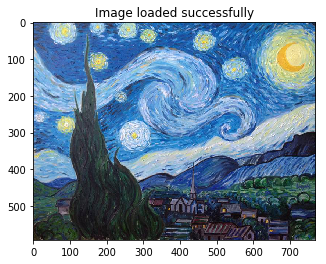

In [31]:
night_sky = load_image('data/starry_night.jpg')

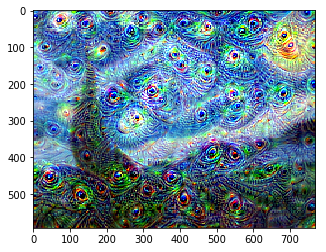

In [32]:
night_sky_32 = deep_dream_vgg(night_sky, 32, 6, 0.2)

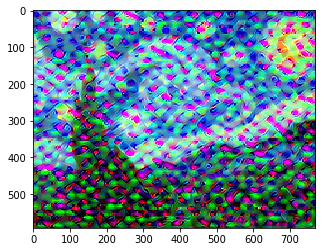

In [33]:
night_sky_8 = deep_dream_vgg(night_sky, 8, 6, 0.2)

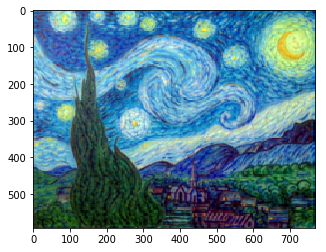

In [34]:
night_sky_4 = deep_dream_vgg(night_sky, 4, 6, 0.2)